# Feast v0.8 Mock - Online Retail

This notebook presents high level, a end to end mock of the v0.8 API to build one the predict Customer Churn of a Telecom company.

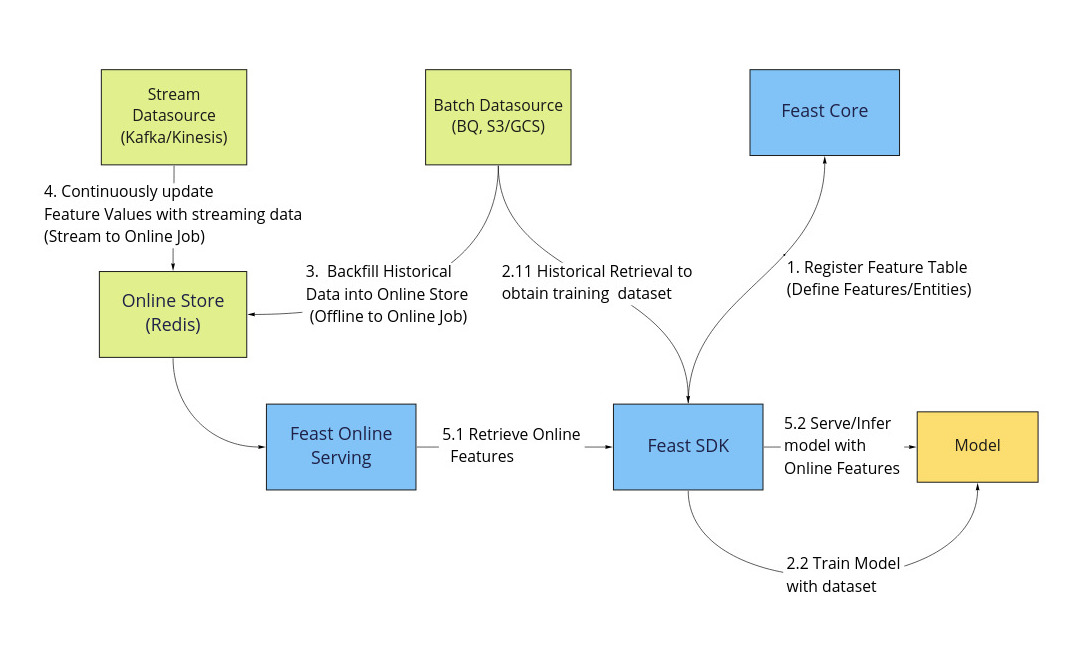

Overview:
1. Registering Features and Entities with Feature Tables with Feast Core.
2. Exporting a training data with Historical Retrieval from Feast Serving.
3. Backfilling historical data into the Online Store with an Feast Offline to Online Job.
4. Streaming online data to into the Online Store with an Feast Stream to Online Job.
5. Serving online models with Online Features from Feast Online Serving.



## Prerequisites
This notebook assumes that you already have a Feast deployment up and running.
If you have not done so, deploy Feast with one of [its deployment methods](https://docs.feast.dev/v/master/getting-started/deploying-feast).

> We recommand the docker-compose deployment if you are just starting out.

### Install Python Packages
- Install the Python Packages used this notebook:

In [ ]:
%pip install numpy==1.18.5 pandas==1.1.2 pyspark==3.0.1 confluent-kafka==1.5.0 flask==1.1.2 scikit-learn==0.22.2.post1 pandavro==1.5.2 # feast==0.8.0 

- Restart the kernel to import the newly installed packages:

In [ ]:
import os
import io
import time
import numpy as np
import pandas as pd
import pandavro
import joblib
from datetime import datetime
from random import randint
from confluent_kafka import Producer
from multiprocessing import Process
from sklearn.svm import LinearSVC
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
#from feast import FeatureTable,  Client, 
#from feast.data_source import SourceType, ValueType, ParquetFormat, AvroFormat

In [ ]:
pipeline = make_pipeline(
        ColumnTransformer([
            ("binary_cols", OrdinalEncoder(), 
             ["SeniorCitizen", "Partner", "Dependents", "PhoneService", "OnlineSecurity", "gender",
              "OnlineBackup", "DeviceProtection", "TechSupport",	"StreamingTV", "StreamingMovies", "PaperlessBilling" ]),
            ("cateogical_cols", OneHotEncoder(),
             ["MultipleLines", "InternetService", "Contract", "PaymentMethod"]),
            ("numeric_cols", StandardScaler(),
             ["MonthlyCharges", "TotalCharges"]),
        ]),
        LinearSVC()
    )

- Create and Use the Feast SDK Client to check connectivity to each [Feast Components](https://docs.feast.dev/user-guide/architecture)


In [ ]:
feast = Client(
    core_url=os.environ['FEAST_CORE_URL'],
    serving_url=os.environ['FEAST_SERVING_URL'],
)
feast.ping()

# Framing the  Problem


Problem: Build low-lantency system that can be used to predict Customer Churn 
of a Telecom Company:
- A customer has "churned" if they left the Telecom Company.
- Predict whether a customer would Churn so that that the Marketing Team can target their incentives on those those who are likely to churn.
- Features


Task:

- Train a model to predict whether the a customer would churn.
- Create a low-latency inference that serves the model's predictions.


> Read up on what each feature does in the [dataset description](https://www.kaggle.com/blastchar/telco-customer-churn)


# Prepare the Data
Prepare the the dataset into a format which Feast is able to source:
- In this example, we prepare the data to be consumed by Feast's `FileSource` data source.

> This step can be automated with an ETL pipeline, which can be scheduled to provide periodic updates to feature values.

---

- Download &amp; and load the the data:

In [ ]:
df = pd.read_csv('http://feast-examples.storage.googleapis.com/telco-churn-xgboost/telco_customer_churn.csv')
df.head()

,customer_id,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


- Load & Preprocess the historical data


In [ ]:
df["TotalCharges"] = df["TotalCharges"].replace(" ", pd.NA)
df = df.dropna().astype({"TotalCharges": "float64"})
# Replace 'No internet service' to No for the following columns
replace_cols = [ 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                'TechSupport','StreamingTV', 'StreamingMovies']
df[replace_cols] = df[replace_cols].replace({'No internet service' : 'No'})
# Replace binary values with strings
df["SeniorCitizen"] = df["SeniorCitizen"].replace({1:"Yes",0:"No"})
# Add timestamp to the features to tell feast when values was last updated
df["Timestamp"] = datetime.now()

- Write data as Parquet

In [ ]:
df.to_parquet("churn.parquet")

# Registering Features with Feast
To register Features with Feast:
- Create Entit(ies) which the features provide descriptive attributes about.
- Register Features by Registering Feature Table with Feast.
- Define a Data Source for in the Feature Table so Feast would know how to source &amp; ingest feature values.


## Entities
[Entities](https://docs.feast.dev/user-guide/entities) are domain objects which features are associated to provide descriptive attributes:
- Feast uses these entities as retrieval keys when retrieval feature values.

In [ ]:
customer = Entity(
    name="customer_id",
    value_type=ValueType.STRING,
    description="Defines a customer of the Telecom company represented as ID"
)
feast.apply_entity(customer)

## Features
Features define a certain attribute of an entity:

In [ ]:
df_value_mapping = {
    "O": ValueType.STRING,
    "float64": ValueType.DOUBLE,
    "int64": ValueType.INT64,
}

# Define features by mapping dataframe columns to feature
# Skip columns used for special purposes such as entity or event tiemstamp.
features = [
    Feature(name=col, value_type=df_value_mapping[str(df[col].dtype)])
    for col in df.cols if not col in ["customer_id", "Timestamp"]
]



## Data Sources
Data Sources specify to feast how to obtain values for the Features/Entities:
- Batch data sources provide finite values for features/entities and are useful
   for backfilling historical data.
- Stream data sources provide continuous updates to features'/entities' values and are useful for constantly changing features.

In [ ]:
# Define datasource for Feature Tables
  churn_file = FileSource(
      file_format=ParquetFormat(),
      # Here we are refering a local file
      # Use a file from a cloud storage bucket by using a bucket specific URL:
      # s3://path/to/churn.parquet - use file from a AWS S3 bucke 
      # gs://path/to/churn.parquet - use file from a GCP GCS bucket
      uri=f"file:///{os.getcwd()}/churn.parquet",
      event_timestamp_column="Timestamp",
)


## Feature Tables
Features are defined in ingestion groups as Feature Tables:
- Feature Tables associate Entities with their Features, allowing entity values to be used to retrieve feature values from Feast. Features in the same table share the same entities.
- Each group of Features in a Feature Tables are ingested/populated with feature data/values together (ie values sourced same data source)
- Data Sources defined in Feature Tables to define how data/values is sourced for each feature/entity in the table.

In [ ]:
# Feature table for churn features
# Associates features with entities and their datasource.
churn_ft= FeatureTable(
    name="churn",
    entities=[customer.name, item.name],
    features=features,
    offline_source=churn_source,
)
feast.apply_feature_table(churn_ft)

# Training a Model

Train a Model with Feast:
- Create a Model to train.
- Retrieving Historical Features to obtain a training dataset.
- Training the model with a Training Dataset obtained from Feast.

### Creating a Model



In [ ]:
binary_cols = [
  "SeniorCitizen", "Partner", "Dependents", "PhoneService", 
  "OnlineSecurity", "gender", "OnlineBackup", "DeviceProtection",
  "TechSupport",	"StreamingTV", "StreamingMovies", "PaperlessBilling",
]
cat_cols = ["MultipleLines", "InternetService", "Contract", "PaymentMethod"]
num_cols = ["MonthlyCharges", "TotalCharges"]

class ChurnModel:
  def __init__(self, binary_cols, cat_cols, num_cols):
    self.feature_names = binary_cols + cat_cols + num_cols
    self.label_col = "Churn"
  
    # Build Model pipeline with data transforms and Linear-SVM model
    self.pipeline = make_pipeline(
        ColumnTransformer([
            ("binary_cols", OrdinalEncoder(), binary_cols),
            ("categorical_cols", OneHotEncoder(), cat_cols),
            ("numeric_cols", StandardScaler(), num_cols),
        ]),
        LinearSVC()
    )
  
  def train(self, train_df):    
    inputs, labels = train_df[self.feature_cols], train_df[self.col]
    self.pipeline.fit(inputs, labels)
  
  def predict(self, test_df):
    inputs = train_df[self.feature_cols]
    return self.pipeline.predict(inputs)

### Retrieving Historical Features
Features can now be retrieved from Feast to train a model with `get_historical_features()`:
- Feast retrieves features finding by the feature value that matches:
    - Entity with the specific value. (ie Customer with ID `7590-VHVEG`)
    - Timestamp specifying the point in time to retrieve the feature value relative the feautre value's to its event timestamp

> The timestamp provide is used to perform [Point in Time feature retrieval](https://docs.feast.dev/user-guide/feature-retrieval)

In [ ]:
# obtain a training dataset from feast via historical retrieval
feast.get_historical_features(
    entity=df_ts[[f]]
    features=[f.name for f in features],
    # Retireved Historical Features are written to this URL:
    destination=f"file:///{os.getcwd()}/training.parquet",
)

## Training the Model
-  Use the training dataset obtained from Feast to train the model

In [ ]:
# train the model
df = pd.read_parquet(f"file:///{os.getcwd()}/training.parquet")
train_df, test_df = train_test_split(df)
model.train(train_df)

# save the trained model for use later in the inference service
joblib.dump(model, "model.joblib")

# Inference Service
To build the Inferenced Service that serves predictions from the trained model:
- Backfill historical data into the Feast online store (Redis) using the offline to online job.
- Enable the stream to online job for Features that are continously updating so that the feature values in the online store stay up to date.
- Create Inference Service that makes predictions using the model and feature data obtained from Feast.

## Backfill Historical Data
Backfill Historical Data to prepopulate the Online Store with Historical Data
- Create a Offline to Online Job which would start syncing the historical data with the online store.
- This allows the online serving to serve of batched historical data synced to the online store.



In [ ]:
feast.contrib.sync_offline_to_online(    
    feature_table=churn_ft,
    start_time=df["Timestamp"].min(),
    end_time=df["Timestamp"].max(),
)

## Stream Online Data
Streaming Online Data allows continous updates to feature values from a stream data source:


- Create a fake Kafka producer to simlulate avro messages which feast would consume to update feature values:

In [ ]:
kafka = Producer({ "bootstrap.servers": os.environ["KAFKA_SERVERS"] })

feature_topic = "churn_features"
def produce_fake_stream():
  # Produce fake stream of Avro Kafka messages
  while True:
    # Since we don't have data to update our features with
    # we sample data from our dataframe to "update" our feature values.
    avro_buffer = io.BytesIO()
    pandavro.to_avro(avro_buffer, df.sample(5))
    kafka.produce(feature_topic, avro_buffer.getvalue())
    kafka.flush()

producer = Process(target=produce_fake_stream)
producer.start()

- Configure Feast to consume the messages and update features by configuring a Kafka streaming data source:


In [ ]:
item_ft.online_source = KafkaSource(
    message_format=AvroFormat(schema_json=pandavro.__schema_infer(df, False)),
    ts_field="timestamp")
feast.apply_feature_table(item_ft)

- Start the stream to online Feast job to sync the feature data in the online store with the data stream:

In [ ]:
stream_job = client.contrib.start_stream_to_online_ingestion(    
    feature_table=churn_ft
)
# our churn features features are now continously updated by the data stream
# (in the form of Avro-formatted Kafka messages).

## Creating Inference Service
Create Model Inference/Prediction Service:
- Exposes an `/predict` endpoint conducts model inference and makes a prediction.
- Sources the required feature data to make an inference from Feast's online serving.
- Online serving retrieves data from Redis, thereby allows feature data requests to be served at low latency.

In [ ]:
%%writefile service.py

import joblib
import pickle
import pandas as pd

from feast import Client
from flask import Flask, request, json

app = Flask(__name__)
model = joblib.load("model.joblib")
feast = Client(
    core_url=f"{os.environ['FEAST_CORE_URL']}",
    serving_url=f"{os.environ['FEAST_SERVING_URL']}",
)

@app.route("/predict", methods=["POST"])
def route_predict():
  customer_id = request.json["customerId"]
  # Retrieve online feature data from Feast's online serving that the requested entity
  features = feast.get_online_featuresv2(
    features=model.feature_names,
    entities={
      "customer_id": customer_id,
    }
  ).to_dict()
  inputs = pd.DataFrame(features)
  pred = "churn" if model.predict(inputs)[0] == 1 else "nochurn"
  return jsonify({"prediction": pred })

app.run(host="0.0.0.0", port="8989")

Writing service.py


- Run Service:

In [ ]:
!nohup bash -c "python service.py &>service.log" &
!bash feast/infra/scripts/wait-for-it.sh localhost:8989
!cat service.log

- Make inference request:

In [ ]:
curl -X POST -H "Content-Type: application/json" --data '{"customerId":"7795-CFOCW"}' http://localhost:8989/predict